# Transformer for Language Translation implementation in PyTorch

In this notebook I will go trough an PyTorch implementation of transformer based on [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.

In [another notebook](https://github.com/mf1024/transformers) I implemented Transforer Encoder model and trained it for Language Modeling task. 

In this notebook I will continue and add the Decoder component to the implementation and train the whole on Language Translation task.

Troughout this notebook as well I **use some of the illustrations from the incredible [Illustrated transformer](https://jalammar.github.io/illustrated-transformer) blog post by *Jay Alammar***. I highly recommend you to take a look at it. 


## Dataset

For the translation task I will use a small english-french [dataset](https://raw.githubusercontent.com/mf1024/transformers/master/fra-eng/fra.txt). The dataset consists of just 170k sentences but that is enough to train and demonstrate the Transformer.

I will use the same PyTorch [Dataset](https://github.com/mf1024/transformers/blob/master/fra_eng_dataset.py) implementation to process the sentences and prepare the batches.


## Transformer architecture:

<img src="imgs/transformer.png">

The key idea of Transformer is to avoid using [reccurence](https://arxiv.org/abs/1409.3215) at all for encoding and decoding variable-length sequences. That solves issues with long-range dependencies and the amount of computation that can be parallelized.

The transformer consists of two parts - the Encoder and the Decoder. They are both very similar in their structure but different in a few aspects. 

## The Encoder and Decoder

<img src="imgs/encoder-decoder.png">

In the full Transformer implementation, first, the sentence in the source language is encoded. One the encoding is done, the output of the last encoder layer is used in every layer of decoder, where the last layer generates the sentence in target language. 


<img src="imgs/transformer_decoding.gif">

The Decoder layer consists of same sublayers as Encoder(Self Attention and Feed Forward) with one additional sublayer - Memory Attention. The Memory Attention sublayer is similar to Self Attention except it uses **Key** and **Value** matrices from the Encoder.

The Decoder will use these **Key** and **Value** matrices but will learn to calculate it's own **Query** to gather the information from the encoded sentences.

When decoding the sentence, each word is prediced one at a time, meaning that for Decoder to predict the word x(i) the input of the Decoder should be all the words in target langugae from 1 to i-1 . During the traing the decoding can be paralelized using masking, but during translation it is going to take as many Decoder runs as there are words in the target sentence as shown in the GIF. 

In [13]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from fra_eng_dataset import FraEngDataset, fra_eng_dataset_collate
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Attention Layers

In [2]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, padding_mask = None, subsq_mask = None):
        # x shape: [N, SEQ, D_MODEL]

        keys = self.K.forward(x)
        values = self.V.forward(x)
        queries = self.Q.forward(x)

        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the sentence
        if padding_mask is not None:
            att = att + padding_mask.transpose(1,2)
        # Add subsequent mask so that each position can attend only itself and the previous elements
        if subsq_mask is not None:
            att = att + subsq_mask.unsqueeze(0)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ, SEQ]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ, D_MODEL]

        return att_out, keys, values

### Memory Attention
Implementation is the same as Self Attention only the keys and values matrices are not calculated from weights and input but are passed to the forward function.

In [ ]:
class MemAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, mem_padding_mask, keys = None, values = None):

        # X shape: [N, SEQ, D_MODEL]
        queries = self.Q.forward(x)
        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ_TGT, SEQ_SRC]

        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the source sentence
        if mem_padding_mask is not None:
            att = att + mem_padding_mask.transpose(1,2)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ_TGT, SEQ_SRC]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ_TGT, D_MODEL]

        return att_out

### Multi-head attentions for Self Attention and Memory Attention

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        out_cat = None
        keys = None
        values = None

        for i in range(self.num_heads):
            head_outp, keys, values = self.heads[i].forward(src, src_padding_mask, src_subsq_mask)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret, keys, values

In [ ]:

class MultiHeadMemAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([MemAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, keys, values):

        out_cat = None
        for i in range(self.num_heads):
            head_outp = self.heads[i].forward(src, src_padding_mask, keys = keys, values = values)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret

### Encoder layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.att_sublayer_norm = torch.nn.LayerNorm(d_model)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout_lin = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout2 = nn.Dropout(dropout)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        residual_1 = src
        x, keys, values = self.multihead_attention.forward(src, src_padding_mask, src_subsq_mask)
        x = self.att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_2 + self.dropout2(x))

        return x, keys, values

### Decoder layer

The only difference between Encoder and Decoder layer is the additional MultiHeadMemAttention() sublayer in the decoder layer.

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_self_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.self_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.multihead_mem_attention = MultiHeadMemAttention(d_model, num_att_heads)
        self.mem_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.dropout_lin = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):

        residual_1 = x
        x, keys, values = self.multihead_self_attention.forward(x, tgt_padding_mask, tgt_subsq_mask)
        x = self.self_att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.multihead_mem_attention.forward(x, src_padding_mask, keys = mem_keys, values = mem_values)
        x = self.mem_att_sublayer_norm.forward(residual_2 + self.dropout2(x))

        residual_3 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_3 + self.dropout3(x))

        return x

## Positional Encoding

The attention module itself have no information about the position of other word embeddings in the sentence. In NLP and other sequential data tasks the order of the sequence is critical. To solve this issue the authors of the paper introduce the Positional Encoding method. First they generate a vector containing information about the position in the same size as the embedding and then simply add this vector to the word embedding and hope that the model will learn to recognize it.

They use the following function to generate the positional information: 
<img src="imgs/pos_enc.png">


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.sin_args = torch.zeros(1, self.d_model).to(device)
        self.cos_args = torch.zeros(1, self.d_model).to(device)
        for i in range(self.d_model//2):
            self.sin_args[0,i * 2] = 10000**(2.*i/self.d_model)
            self.cos_args[0,i * 2 + 1] = 10000**(2.*i/self.d_model)

        self.sin_args_mask = (self.sin_args > 1e-10).float()
        self.sin_args = self.sin_args + (self.sin_args < 1e-10).float()

        self.cos_args_mask = (self.cos_args > 1e-10).float()
        self.cos_args = self.cos_args + (self.cos_args < 1e-10).float()

    def forward(self, x):
        for pos in range(x.size()[-2]):
            x[:,pos,:] = x[:,pos,:] + \
                         torch.sin(pos / self.sin_args) * self.sin_args_mask + \
                         torch.cos(pos / self.cos_args) * self.cos_args_mask

        return x


Here is a vizualization of the positional encoding vectors. Each row is an encoding for a word. 

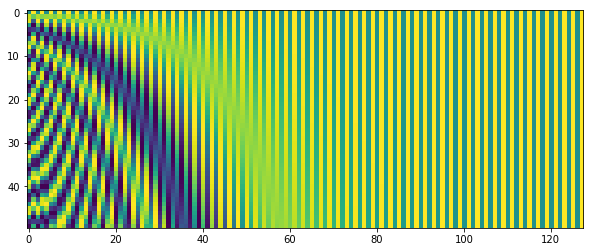

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

positional_enc = PositionalEncoding(128).to(device)
data = torch.zeros(1, 50, 128).to(device)
data_pos_enc = positional_enc.forward(data)

enc_np = data_pos_enc.squeeze(dim=0).to('cpu').numpy()
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(enc_np)
plt.show()